# Table of Contents
1. [Import-Modules](#Import-Modules)
   2. [Install-Required-Modules](#Install-Required-Modules)
   3. [Load-Modules](#Load-Modules)
3. [Read-Files](#Read-Files)
4. [Pre-Processing-Data](#Pre-Processing-Data)
   1. [Data Cleaning](#cleaning)
   2. [Feature Engineering](#features)
5. [Exploratory-Data-Analysis](#Exploratory-Data-Analysis)
6. [Results Analysis](#results)

## Import Modules

### Install Required Modules

In [ ]:
!pip install geopy
!pip install rasterio

### Load Modules

In [2]:
import pandas as pd
import numpy as np
import glob
import os
import re

import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import HeatMap

from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


## Read Files
#### Read the files and combine them into one single csv and save it in the directory

In [4]:
# Detect delimiter
def detect_delimiter(file_path):
    with open(file_path, 'r') as f:
        for _ in range(10):
            line = f.readline()
            if ',' in line and '\t' not in line:
                return ','
            elif '\t' in line and ',' not in line:
                return '\t'
    return ','

# Read and clean one file
def read_and_clean_file(file):
    delimiter = detect_delimiter(file)

    with open(file, 'r') as f:
        lines = f.readlines()

    header_index = next((i for i, line in enumerate(lines) if 'Date' in line and 'Time' in line), 9)

    # --- Extract metadata ---
    metadata_lines = lines[:header_index]
    metadata = {}
    for line in metadata_lines:
        if ':' in line:
            key, value = line.split(':', 1)
            metadata[key.strip()] = value.strip().rstrip(',')

    try:
        df = pd.read_csv(file, delimiter=delimiter, skiprows=header_index)

        # Standardize columns 
        rename_map = {
            'Site latitude (deg)': 'Site latitude',
            'Site longitude (deg)': 'Site longitude',
            'Date (dd.mm.yyy)': 'Date',
            'Date (dd.mm.yyyy)': 'Date',
            'Time (hh:mm:ss)': 'Time',
            'Rx Latitude (deg)': 'Rx Latitude',
            'Rx Longitude (deg)': 'Rx Longitude',
            'Local mean measurement (dBm)': 'Local dBm',
            'Local mean measurement': 'Local dBm'
        }
        df.rename(columns=rename_map, inplace=True)

        # Try to find and rename 'Local dBm'
        if 'Local dBm' not in df.columns:
            signal_col = next((col for col in df.columns if re.search(r'local.*(mean|measurement).*dbm', col, re.IGNORECASE)), None)
            if signal_col:
                df.rename(columns={signal_col: 'Local dBm'}, inplace=True)
            else:
                print(f"[!] Skipping file (no 'Local dBm'): {file}")
                return None

        df.columns = df.columns.astype(str).str.strip().str.replace(r'\s+', ' ', regex=True)
        df = df.loc[:, ~df.columns.str.contains("^Unnamed|^nan$", case=False)]

        # Convert signal to numeric and filter using noise floor
        df['Local dBm'] = pd.to_numeric(df['Local dBm'], errors='coerce')
        try:
            noise_floor = float(metadata.get("System noise floor (dBm)", -999))
            df = df[df['Local dBm'] > (noise_floor + 6)]
        except ValueError:
            pass

        # Attach all metadata as new columns
        for key, value in metadata.items():
            df[key] = value

        # Extract Site latitude/longitude from metadata if not in df
        if 'Site latitude' not in df.columns or df['Site latitude'].isna().all():
            lat = metadata.get('Site latitude (deg)') or metadata.get('Site Latitude (deg)')
            if lat:
                df['Site latitude'] = float(lat)

        if 'Site longitude' not in df.columns or df['Site longitude'].isna().all():
            lon = metadata.get('Site longitude (deg)') or metadata.get('Site Longitude (deg)')
            if lon:
                df['Site longitude'] = float(lon)

        df['source_file'] = file
        return df

    except Exception as e:
        print(f"[!] Failed to parse {file}: {e}")
        return None


# Load and process all CSV files
file_list = glob.glob("Data/Code_Data/**/*.csv", recursive=True)
dfs = []

for file in file_list:
    df = read_and_clean_file(file)
    if df is not None:
        dfs.append(df)

# Align all columns
all_columns = sorted(set(col for df in dfs for col in df.columns))
for i, df in enumerate(dfs):
    missing = set(all_columns) - set(df.columns)
    for col in missing:
        df[col] = pd.NA
    dfs[i] = df[all_columns]

# Combine everything
combined_df = pd.concat(dfs, ignore_index=True)

# Drop duplicate column variants
for col in ['Site latitude (deg)', 'Site longitude (deg)', 'Date (dd.mm.yyy)', 'Date (dd.mm.yyyy)']:
    if col in combined_df.columns:
        combined_df.drop(columns=col, inplace=True)

# Convert coordinates to float
for col in ['Site latitude', 'Site longitude', 'Rx Latitude', 'Rx Longitude']:
    if col in combined_df.columns:
        combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

# Clean frequency and site name for filtering 
combined_df["Site name"] = combined_df["Site name"].astype(str).str.strip()
combined_df["Frequency (MHz)"] = combined_df["Frequency (MHz)"].astype(str).str.strip().astype(float)

# Drop duplicates
combined_df.drop_duplicates(inplace=True)

# Save final output
combined_df.to_csv("Data/Output/Combined_with_Metadata.csv", index=False)

print("✅ Combined file created with metadata, site lat/lon, noise filtering, and unified structure.")

✅ Combined file created with metadata, site lat/lon, noise filtering, and unified structure.


## Pre-Processing Data

### Pre- Cleaning checks

In [8]:
# combined_df[['"Adjusted e.i.r.p. (dBm)','"Site name',"Site name",'"Frequency (MHz)',"Frequency (MHz)","Adjusted e.i.r.p. (dBm)"]].drop_duplicates()
combined_df.head().to_clipboard()

### Post Cleaning check process

In [11]:
# Cleaning the column names (trimming the space before and after the name")
combined_df.columns = combined_df.columns.str.strip()
combined_df = combined_df.applymap(lambda x: ''.join(str(x).split()) if isinstance(x, str) else x)

/var/folders/6_/lnnlyvg97bv1fbtwyqqth9z80000gn/T/ipykernel_43818/1820247339.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  combined_df = combined_df.applymap(lambda x: ''.join(str(x).split()) if isinstance(x, str) else x)


In [12]:
# Create a copy of the original dataset in case it gets corrupt
combined_df_filtered = combined_df.copy()

In [13]:
# Get rid of the duplicates to make the data cleaner
check = combined_df_filtered[["Site name","Adjusted e.i.r.p. (dBm)","Frequency (MHz)"]].drop_duplicates()
check.groupby(["Frequency (MHz)"])["Site name"].count().reset_index()
combined_df_filtered.groupby(["Frequency (MHz)","Site name"])["Adjusted e.i.r.p. (dBm)"].count().reset_index()
# check

Frequency (MHz)    Site name  Adjusted e.i.r.p. (dBm)
0           449.425       Boston                    61248
1           449.425       London                    26149
2           449.425      Merthyr                    21392
3           449.425   Nottingham                    45297
4           449.425     ScarHill                    60723
5           449.425  Southampton                    23347
6           449.425    Stevenage                    35439
7           915.950       Boston                   116080
8           915.950       London                    54402
9           915.950      Merthyr                    42725
10          915.950   Nottingham                    92970
11          915.950     ScarHill                   116268
12          915.950  Southampton                    53597
13          915.950    Stevenage                    71997
14         1802.500       Boston                   200700
15         1802.500       London                    56945
16         1802.500      Merthyr                    72571
17         1802.500   Nottingham                   144312
18         1802.500     ScarHill                   116106
19         1802.500  Southampton                    58092
20         1802.500    Stevenage                    45367
21         2695.000       Boston                   240384
22         2695.000       London                    61588
23         2695.000      Merthyr                    83589
24         2695.000   Nottingham                   165968
25         2695.000     ScarHill                    98209
26         2695.000  Southampton                    63942
27         2695.000    Stevenage                    53853
28         3602.500       Boston                   425094
29         3602.500       London                   128340
30         3602.500      Merthyr                   121184
31         3602.500   Nottingham                   162004
32         3602.500     ScarHill                   247693
33         3602.500  Southampton                   104213
34         3602.500    Stevenage                    94700
35         5850.000       Boston                   549252
36         5850.000       London                   130849
37         5850.000      Merthyr                   178484
38         5850.000   Nottingham                   217394
39         5850.000     ScarHill                   290660
40         5850.000  Southampton                   128458
41         5850.000    Stevenage                   105736

In [14]:
# Combining data and time column and getting rid of the original column
combined_df_filtered['datetime'] = pd.to_datetime(
    combined_df_filtered['Date'] + ' ' + combined_df_filtered['Time (hh:mm:ss)'],
    format='%d.%m.%Y %H:%M:%S'
)
combined_df_filtered.drop(['Date', 'Time (hh:mm:ss)'], axis=1, inplace=True)

## Calculate Transmitter–Receiver Distance
    # •	Computes the straight-line (geodesic) distance between the transmitter and receiver based on their lat/lon coordinates
	# •	tx_coords is the fixed location of the transmitter (usually the same for the whole dataset).
	# •	rx_coords are the varying positions recorded as the receiver moved.
	# •	geodesic(...).km gives you the great-circle distance in kilometers.

In [16]:
combined_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5167321 entries, 0 to 5169322
Data columns (total 13 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   Adjusted e.i.r.p. (dBm)   object        
 1   Frequency (MHz)           float64       
 2   Local dBm                 float64       
 3   Rx Latitude (deg)         float64       
 4   Rx Longitude (deg)        float64       
 5   Rx antenna height (m)     object        
 6   Site latitude             float64       
 7   Site longitude            float64       
 8   Site name                 object        
 9   System noise floor (dBm)  object        
 10  Tx antenna height (m)     object        
 11  source_file               object        
 12  datetime                  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), object(6)
memory usage: 551.9+ MB


In [17]:
# Function to calculate distance for each row safely
def compute_distance(row):
    rx_lat, rx_lon = row['Rx Latitude (deg)'], row['Rx Longitude (deg)']
    tx_lat, tx_lon = row['Site latitude'], row['Site longitude']

    # Check for NaNs
    if pd.isna(rx_lat) or pd.isna(rx_lon) or pd.isna(tx_lat) or pd.isna(tx_lon):
        return np.nan
    
    rx_coords = (rx_lat, rx_lon)
    tx_coords = (tx_lat, tx_lon)
    return geodesic(tx_coords, rx_coords).km

# Apply the safe distance function
combined_df_filtered['Tx_Rx_distance_km'] = combined_df_filtered.apply(compute_distance, axis=1)

# Check output
combined_df_filtered[['Rx Latitude (deg)', 'Rx Longitude (deg)', 'Tx_Rx_distance_km']].head()

Rx Latitude (deg)  Rx Longitude (deg)  Tx_Rx_distance_km
0            50.9467             -1.3093           0.065382
1            50.9467             -1.3090           0.084203
2            50.9467             -1.3087           0.103896
3            50.9465             -1.3083           0.126989
4            50.9464             -1.3080           0.147585

Pearson correlation between Tx_Rx_distance_km and Local_dBm: -0.3511


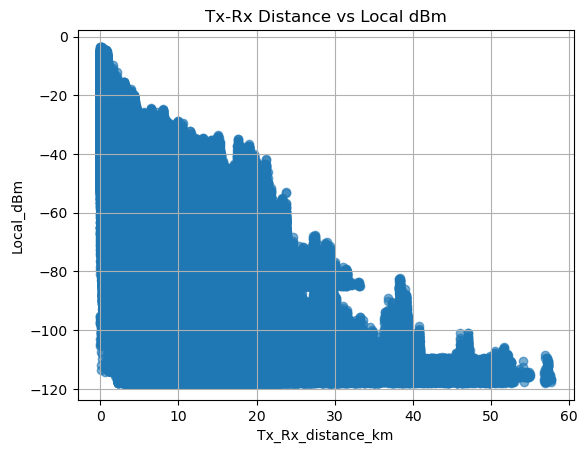

In [18]:
# Drop rows with missing values in relevant columns
df_clean = combined_df_filtered[['Tx_Rx_distance_km', 'Local dBm']].dropna()

# Calculate Pearson correlation
correlation = df_clean['Tx_Rx_distance_km'].corr(df_clean['Local dBm'], method='pearson')

print(f"Pearson correlation between Tx_Rx_distance_km and Local_dBm: {correlation:.4f}")

plt.scatter(df_clean['Tx_Rx_distance_km'], df_clean['Local dBm'], alpha=0.6)
plt.title('Tx-Rx Distance vs Local dBm')
plt.xlabel('Tx_Rx_distance_km')
plt.ylabel('Local_dBm')
plt.grid(True)
plt.show()

In [19]:
# Cleaning the column names (trimming the space before and after the name")
combined_df.columns = combined_df.columns.str.strip()
combined_df = combined_df.applymap(lambda x: ''.join(str(x).split()) if isinstance(x, str) else x)

/var/folders/6_/lnnlyvg97bv1fbtwyqqth9z80000gn/T/ipykernel_43818/1820247339.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  combined_df = combined_df.applymap(lambda x: ''.join(str(x).split()) if isinstance(x, str) else x)


In [21]:
check = combined_df_filtered[["Site name","Adjusted e.i.r.p. (dBm)","Frequency (MHz)"]].drop_duplicates()
check.groupby(["Frequency (MHz)"])["Site name"].count()
# check

Frequency (MHz)
449.425     7
915.950     7
1802.500    7
2695.000    7
3602.500    7
5850.000    7
Name: Site name, dtype: int64

In [22]:
# Combining data and time column and getting rid of the original column
combined_df_filtered['datetime'] = pd.to_datetime(
    combined_df_filtered['Date'] + ' ' + combined_df_filtered['Time (hh:mm:ss)'],
    format='%d.%m.%Y %H:%M:%S'
)
combined_df_filtered.drop(['Date', 'Time (hh:mm:ss)'], axis=1, inplace=True)

KeyError: 'Date'

In [45]:
# Fresnel Radius

# When a radio wave travels from transmitter to receiver, it’s not just the straight line (line-of-sight) that matters — the signal actually spreads out in an ellipsoidal shape around that line. This area is called the Fresnel Zone.
# 	•	If obstacles intrude into the 1st Fresnel zone, they can diffract or scatter the signal, causing loss.
# 	•	To avoid significant signal degradation, the first Fresnel zone should ideally be at least 60% clear of obstructions.

def fresnel_radius(d1_m, d2_m, freq_mhz, zone=1):
    """
    Calculate the radius of the nth Fresnel zone at a point between Tx and Rx.

    Parameters:
    - d1_m: Distance from the point to the transmitter (in meters)
    - d2_m: Distance from the point to the receiver (in meters)
    - freq_mhz: Frequency in MHz
    - zone: Fresnel zone number (1 by default)

    Returns:
    - Fresnel radius in meters
    """
    freq_hz = freq_mhz * 1e6
    c = 3e8  # Speed of light (m/s)
    wavelength = c / freq_hz
    r = np.sqrt((zone * wavelength * d1_m * d2_m) / (d1_m + d2_m))
    return r

# Distance is in km; convert to meters and split evenly for midpoint
d1 = d2 = combined_df_filtered['Tx_Rx_distance_km'] * 500  # meters

# Apply Fresnel radius calculation
combined_df_filtered['fresnel_radius_m'] = fresnel_radius(d1, d2, freq_mhz=449.425)

## Exploratory Data Analysis

In [48]:
combined_df_filtered.describe(include='object').to_csv("summary.csv")

In [49]:
# Summary on preprocessed Data
def summarize_dataset(df):
    print("=> Dataset Shape:")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    print("\n=> Column Data Types:")
    print(df.dtypes)
    print("\n=> Summary Statistics (Numerical Columns):")
    print(df.describe())
    print("\n=> Summary Statistics (Categorical Columns):")
    print(df.describe(include='object'))
    print("\n=> Null Value Count:")
    print(df.isnull().sum())
    print("\n=> Unique Values per Column:")
    print(df.nunique())
    print("\n=> Sample Rows:")
    display(df.head())

summarize_dataset(combined_df_filtered)

=> Dataset Shape:
Rows: 5167321, Columns: 15

=> Column Data Types:
Adjusted e.i.r.p. (dBm)             object
Frequency (MHz)                    float64
Local dBm                          float64
Rx Latitude (deg)                  float64
Rx Longitude (deg)                 float64
Rx antenna height (m)               object
Site latitude                      float64
Site longitude                     float64
Site name                           object
System noise floor (dBm)            object
Tx antenna height (m)               object
source_file                         object
datetime                    datetime64[ns]
Tx_Rx_distance_km                  float64
fresnel_radius_m                   float64
dtype: object

=> Summary Statistics (Numerical Columns):
       Frequency (MHz)     Local dBm  Rx Latitude (deg)  Rx Longitude (deg)  \
count     5.167321e+06  5.167321e+06       5.167321e+06        5.167321e+06   
mean      3.470317e+03 -8.469022e+01       5.321959e+01       -1.242359

Adjusted e.i.r.p. (dBm)  Frequency (MHz)  Local dBm  Rx Latitude (deg)  \
0                    50.1          449.425     -29.45            50.9467   
1                    50.1          449.425     -28.15            50.9467   
2                    50.1          449.425     -28.95            50.9467   
3                    50.1          449.425     -32.30            50.9465   
4                    50.1          449.425     -37.87            50.9464   

   Rx Longitude (deg) Rx antenna height (m)  Site latitude  Site longitude  \
0             -1.3093                   1.5        50.9464         -1.3101   
1             -1.3090                   1.5        50.9464         -1.3101   
2             -1.3087                   1.5        50.9464         -1.3101   
3             -1.3083                   1.5        50.9464         -1.3101   
4             -1.3080                   1.5        50.9464         -1.3101   

     Site name System noise floor (dBm) Tx antenna height (m)  \
0  Southampton                     -122                    17   
1  Southampton                     -122                    17   
2  Southampton                     -122                    17   
3  Southampton                     -122                    17   
4  Southampton                     -122                    17   

                             source_file            datetime  \
0  Data/Code_Data/449/southampton449.csv 2016-10-17 15:07:40   
1  Data/Code_Data/449/southampton449.csv 2016-10-17 15:07:48   
2  Data/Code_Data/449/southampton449.csv 2016-10-17 15:07:54   
3  Data/Code_Data/449/southampton449.csv 2016-10-17 15:08:00   
4  Data/Code_Data/449/southampton449.csv 2016-10-17 15:08:06   

   Tx_Rx_distance_km  fresnel_radius_m  
0           0.065382          3.303174  
1           0.084203          3.748562  
2           0.103896          4.163908  
3           0.126989          4.603475  
4           0.147585          4.962757

<Figure size 1200x600 with 0 Axes>

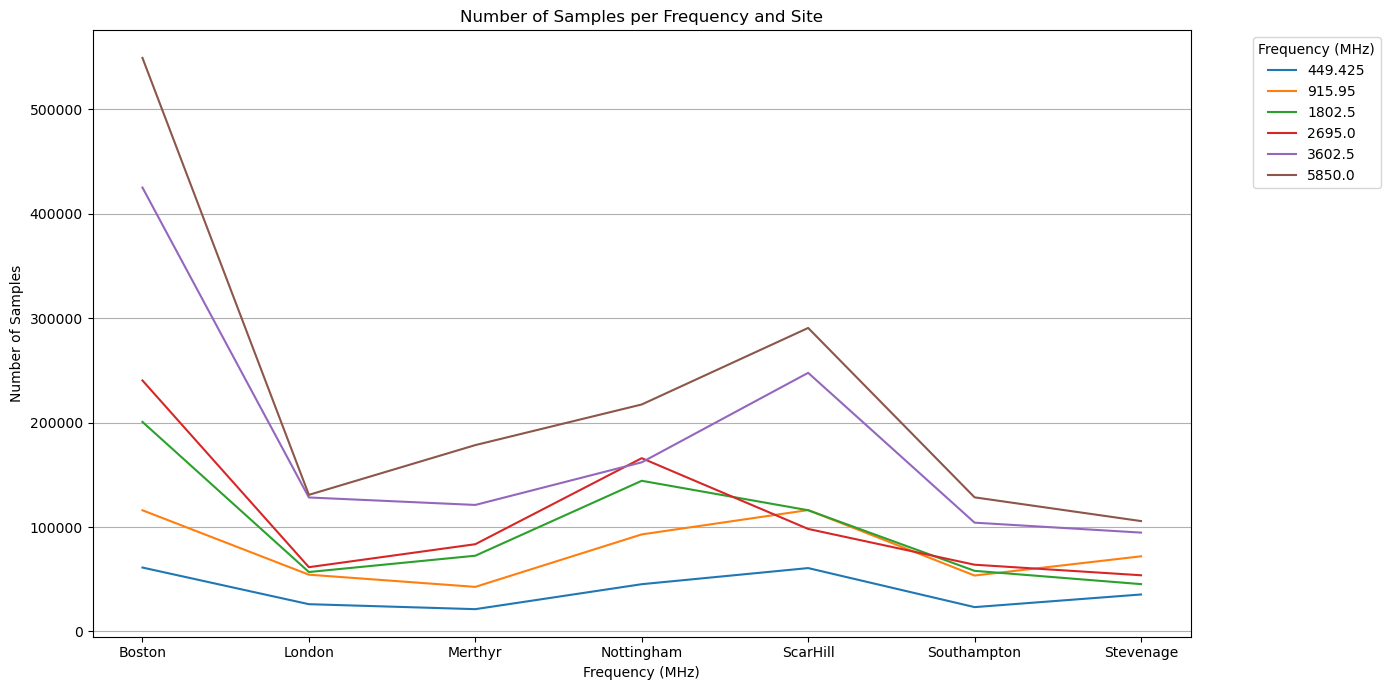

In [51]:
# Bar plot for number of samples in each frequency and site
grouped = combined_df_filtered.groupby(['Frequency (MHz)', 'Site name']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(12, 6))
grouped.T.plot(kind='line', figsize=(14, 7))

plt.title('Number of Samples per Frequency and Site')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Number of Samples')
plt.legend(title='Frequency (MHz)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, axis='y')

plt.show()

<Figure size 1200x600 with 0 Axes>

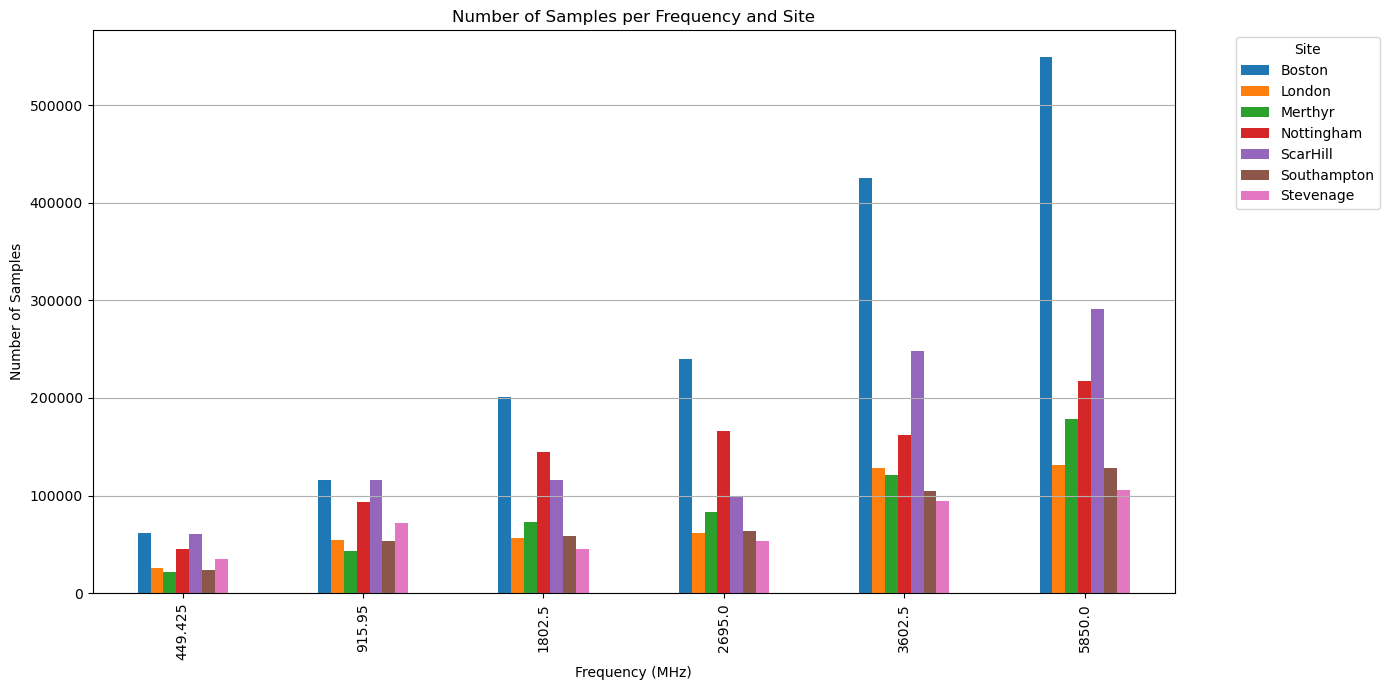

In [52]:
# Bar plot for number of samples in each frequency and site
grouped = combined_df_filtered.groupby(['Site name', 'Frequency (MHz)']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(12, 6))
grouped.T.plot(kind='bar', figsize=(14, 7))

plt.title('Number of Samples per Frequency and Site')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Number of Samples')
plt.legend(title='Site', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, axis='y')

plt.show()

count    5.167321e+06
mean    -8.469022e+01
std      1.942695e+01
min     -1.179900e+02
25%     -9.991000e+01
50%     -8.499000e+01
75%     -7.267000e+01
max     -3.470000e+00
Name: Local dBm, dtype: float64


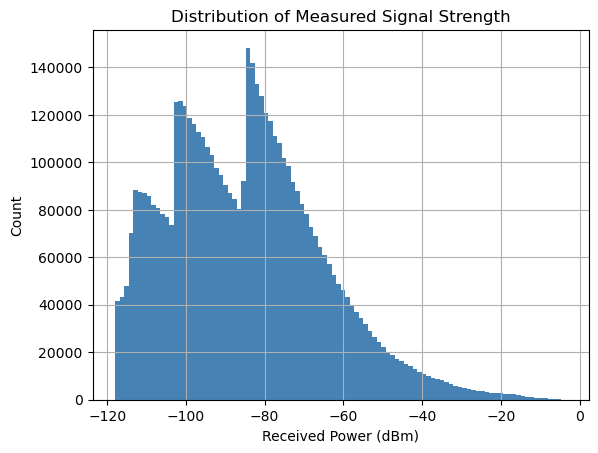

In [53]:
# Summary stats for received signal strength
print(combined_df_filtered['Local dBm'].describe())

# Histogram
import matplotlib.pyplot as plt
plt.hist(combined_df_filtered['Local dBm'], bins=100, color='steelblue')
plt.xlabel('Received Power (dBm)')
plt.ylabel('Count')
plt.title('Distribution of Measured Signal Strength')
plt.grid(True)
plt.show()


 Frequency: 449.425 MHz
count    273595.000000
mean        -93.174320
std          16.148302
min        -115.990000
25%        -105.810000
50%         -95.470000
75%         -83.655000
max         -15.440000
Name: Local dBm, dtype: float64


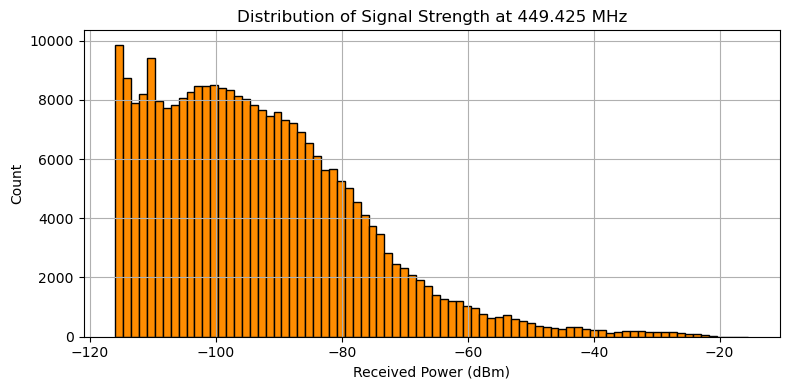


 Frequency: 915.95 MHz
count    548039.000000
mean        -93.682200
std          16.477614
min        -117.990000
25%        -106.640000
50%         -96.040000
75%         -83.400000
max         -18.300000
Name: Local dBm, dtype: float64


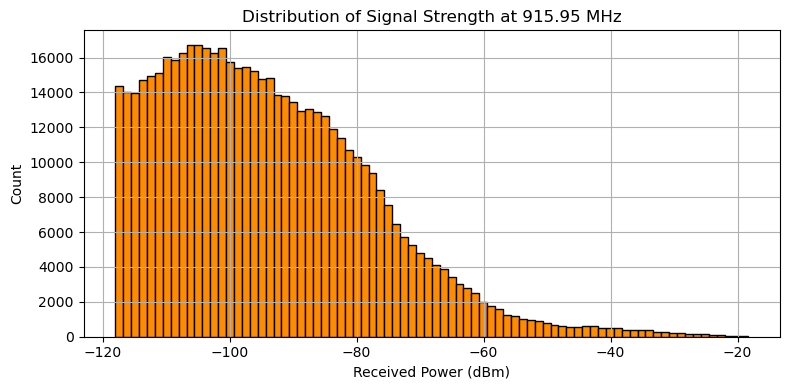


 Frequency: 1802.5 MHz
count    694093.000000
mean        -99.254878
std          14.690852
min        -117.990000
25%        -110.570000
50%        -102.280000
75%         -91.540000
max         -22.910000
Name: Local dBm, dtype: float64


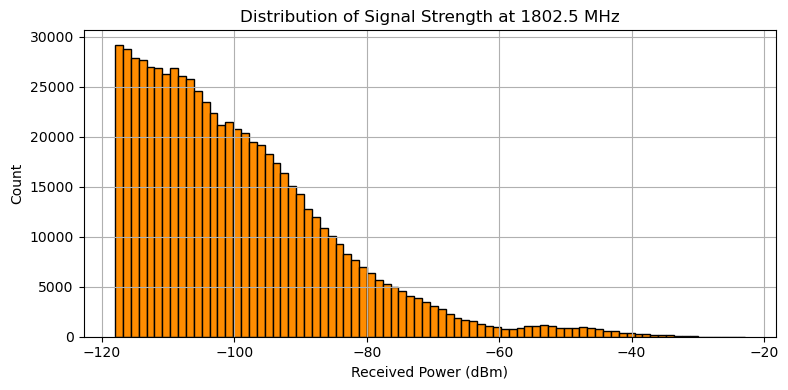


 Frequency: 2695.0 MHz
count    767533.000000
mean        -98.114112
std          13.611003
min        -113.990000
25%        -108.490000
50%        -101.360000
75%         -91.740000
max         -28.870000
Name: Local dBm, dtype: float64


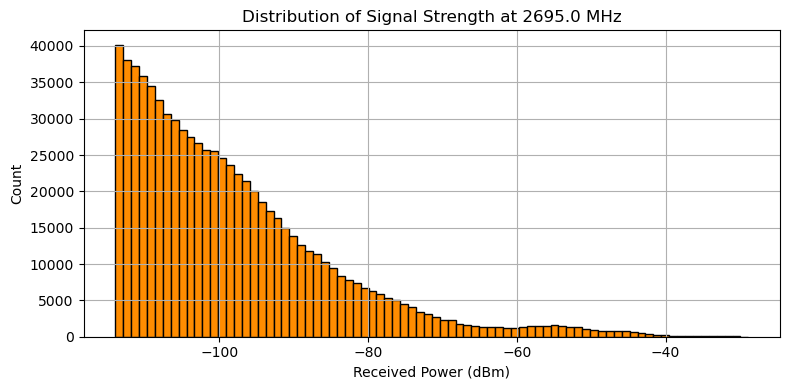


 Frequency: 3602.5 MHz
count    1.283228e+06
mean    -8.470340e+01
std      1.479019e+01
min     -1.029900e+02
25%     -9.604000e+01
50%     -8.795000e+01
75%     -7.721000e+01
max     -1.014000e+01
Name: Local dBm, dtype: float64


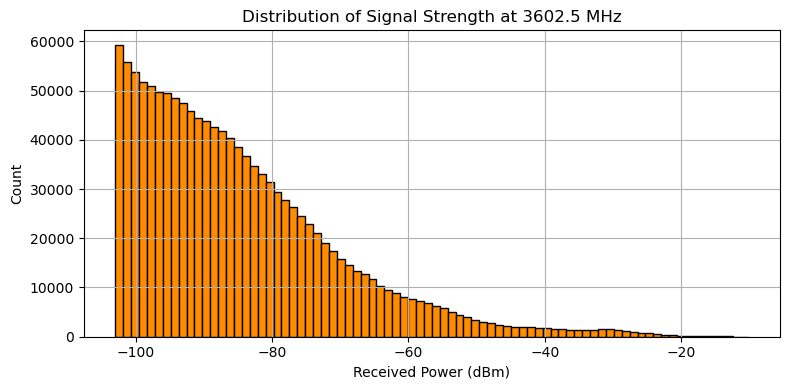


 Frequency: 5850.0 MHz
count    1.600833e+06
mean    -6.740011e+01
std      1.434070e+01
min     -8.499000e+01
25%     -7.846000e+01
50%     -7.070000e+01
75%     -6.017000e+01
max     -3.470000e+00
Name: Local dBm, dtype: float64


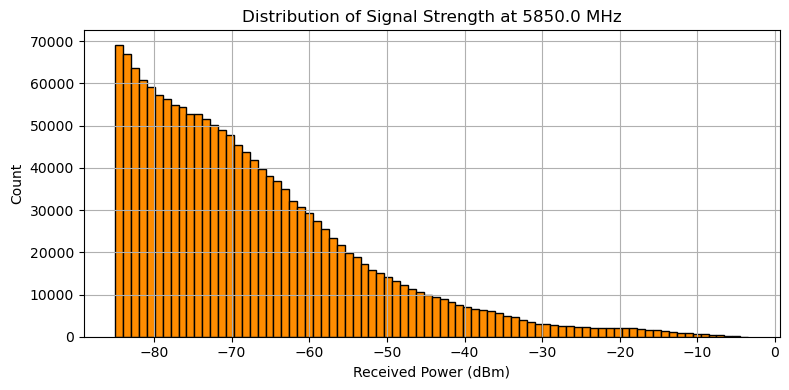

In [54]:
# Get unique frequencies
frequencies = combined_df_filtered['Frequency (MHz)'].dropna().unique()
frequencies.sort()

# Plot for each frequency
for freq in frequencies:
    freq_data = combined_df_filtered[combined_df_filtered['Frequency (MHz)'] == freq]
    
    if freq_data.empty:
        continue

    print(f"\n Frequency: {freq} MHz")
    print(freq_data['Local dBm'].describe())

    plt.figure(figsize=(8, 4))
    plt.hist(freq_data['Local dBm'], bins=80, color='darkorange', edgecolor='black')
    plt.title(f'Distribution of Signal Strength at {freq} MHz')
    plt.xlabel('Received Power (dBm)')
    plt.ylabel('Count')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [56]:
# Rename for convenience
lat_col = 'Rx Latitude (deg)'
lon_col = 'Rx Longitude (deg)'
signal_col = 'Local dBm'  # This seems to represent received signal strength

# Print ranges
print("Latitude Range:", combined_df_filtered[lat_col].min(), "to", combined_df_filtered[lat_col].max())
print("Longitude Range:", combined_df_filtered[lon_col].min(), "to", combined_df_filtered[lon_col].max())
print("Signal Strength (Local dBm) Range:", combined_df_filtered[signal_col].min(), "to", combined_df_filtered[signal_col].max())

# Check for missing values
print("\nMissing values:")
print(combined_df_filtered[[lat_col, lon_col, signal_col]].isnull().sum())

# Preview a few rows
print("\nSample data:")
print(combined_df_filtered[[lat_col, lon_col, signal_col]].head())

Latitude Range: 50.7922 to 57.45462
Longitude Range: -3.866858 to 0.649316
Signal Strength (Local dBm) Range: -117.99 to -3.47

Missing values:
Rx Latitude (deg)     0
Rx Longitude (deg)    0
Local dBm             0
dtype: int64

Sample data:
   Rx Latitude (deg)  Rx Longitude (deg)  Local dBm
0            50.9467             -1.3093     -29.45
1            50.9467             -1.3090     -28.15
2            50.9467             -1.3087     -28.95
3            50.9465             -1.3083     -32.30
4            50.9464             -1.3080     -37.87


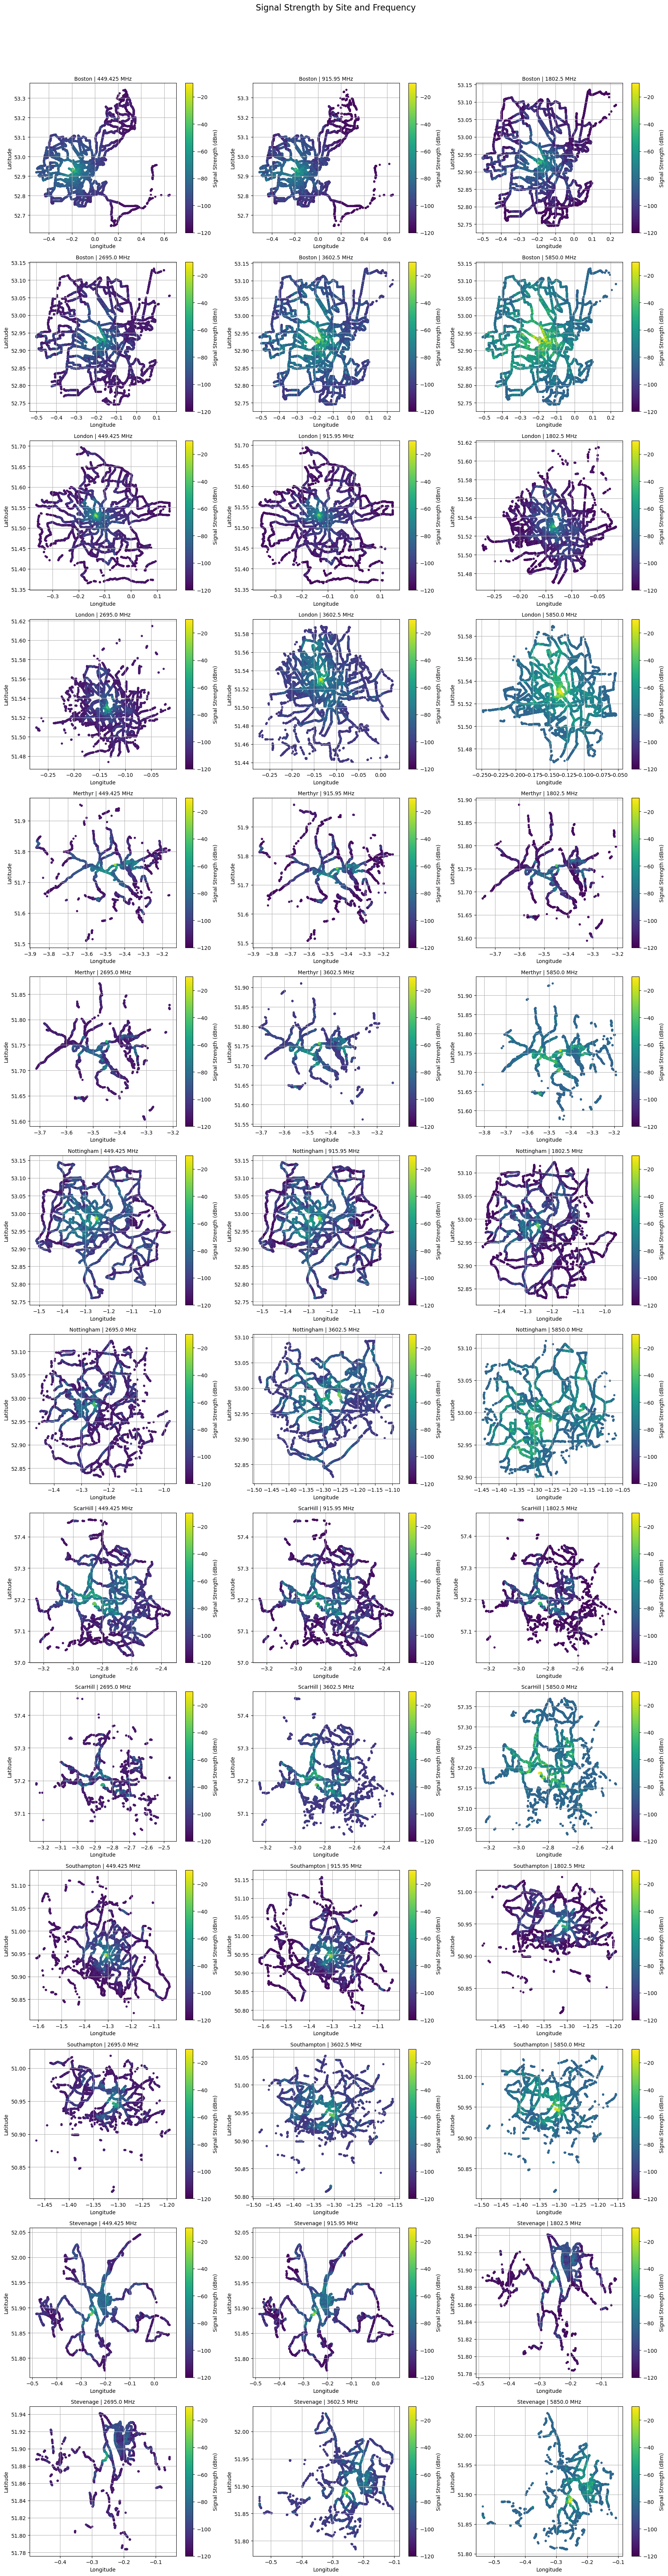

In [57]:
# --- Column definitions ---
lat_col = 'Rx Latitude (deg)'
lon_col = 'Rx Longitude (deg)'
signal_col = 'Local dBm'
site_col = 'Site name'
freq_col = 'Frequency (MHz)'

# --- Unique values ---
unique_sites = sorted(combined_df_filtered[site_col].dropna().unique())
unique_freqs = sorted(combined_df_filtered[freq_col].dropna().unique())

# --- Total number of subplots ---
total_plots = len(unique_sites) * len(unique_freqs)

# --- Dynamic subplot grid size ---
cols = 3
rows = int(np.ceil(total_plots / cols))

# --- Create figure ---
fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 5))
axes = axes.flatten()

plot_idx = 0  # Track which subplot we're on

for site in unique_sites:
    for freq in unique_freqs:
        subset = combined_df_filtered[
            (combined_df_filtered[site_col] == site) &
            (combined_df_filtered[freq_col] == freq)
        ]

        if subset.empty:
            continue

        ax = axes[plot_idx]
        sc = ax.scatter(subset[lon_col], subset[lat_col], c=subset[signal_col],
                        cmap='viridis', s=10, vmin=-120, vmax=-10)

        ax.set_title(f"{site} | {freq} MHz", fontsize=10)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.grid(True)

        cbar = fig.colorbar(sc, ax=ax, orientation='vertical')
        cbar.set_label('Signal Strength (dBm)')

        plot_idx += 1

# --- Remove unused subplots ---
for i in range(plot_idx, len(axes)):
    fig.delaxes(axes[i])

# --- Final layout ---
plt.suptitle("Signal Strength by Site and Frequency", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("signal_strength_by_site_and_freq.png", dpi=300, bbox_inches='tight')
plt.show()

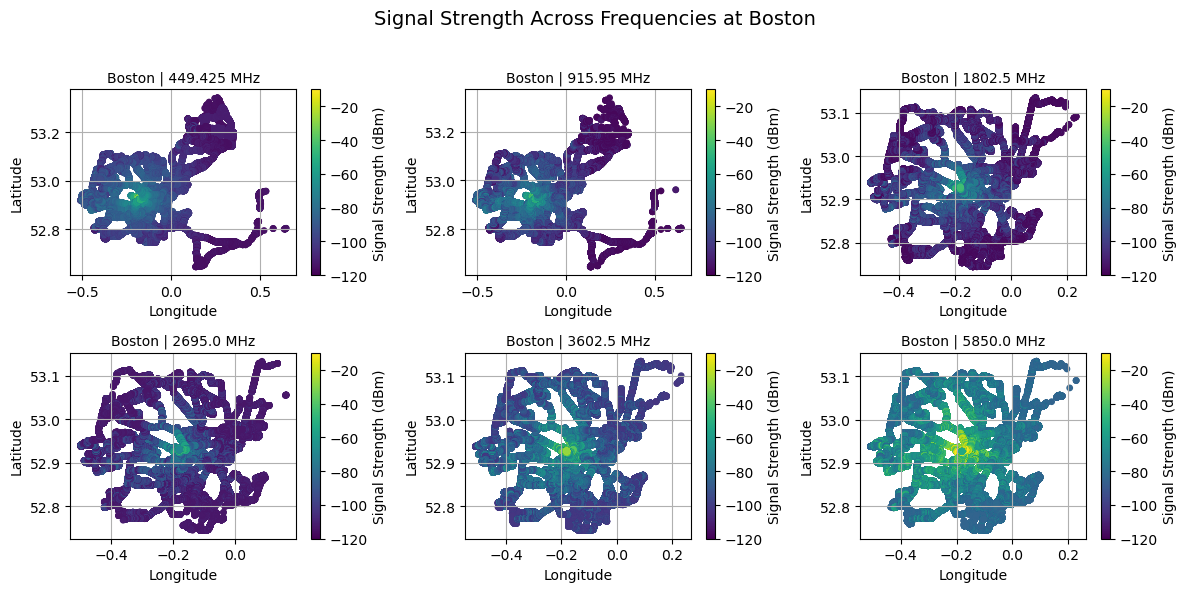

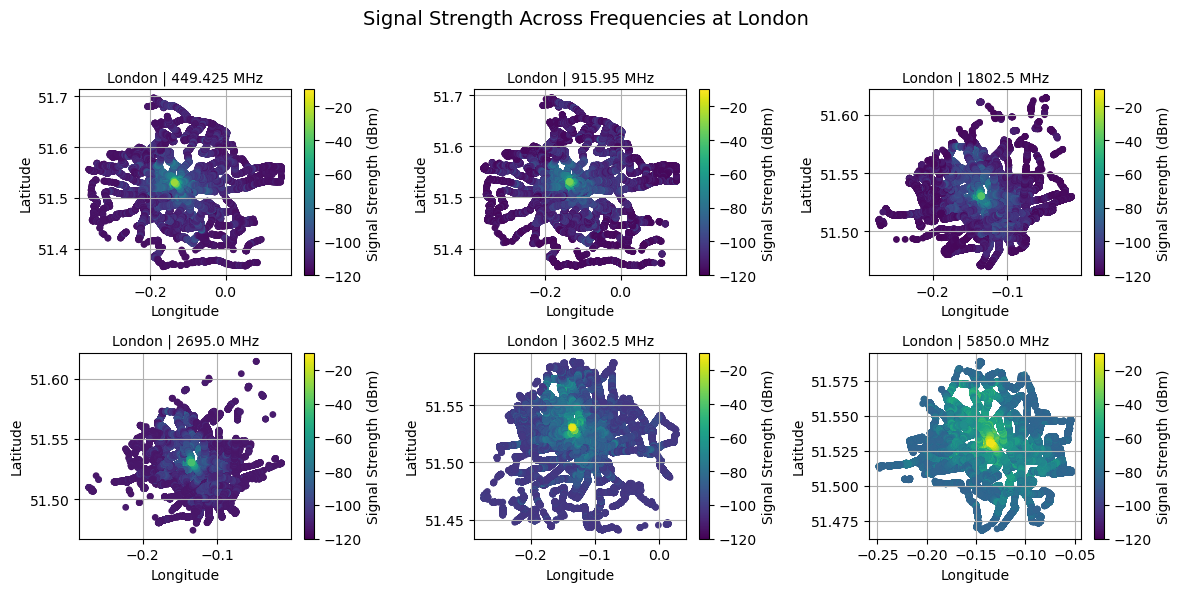

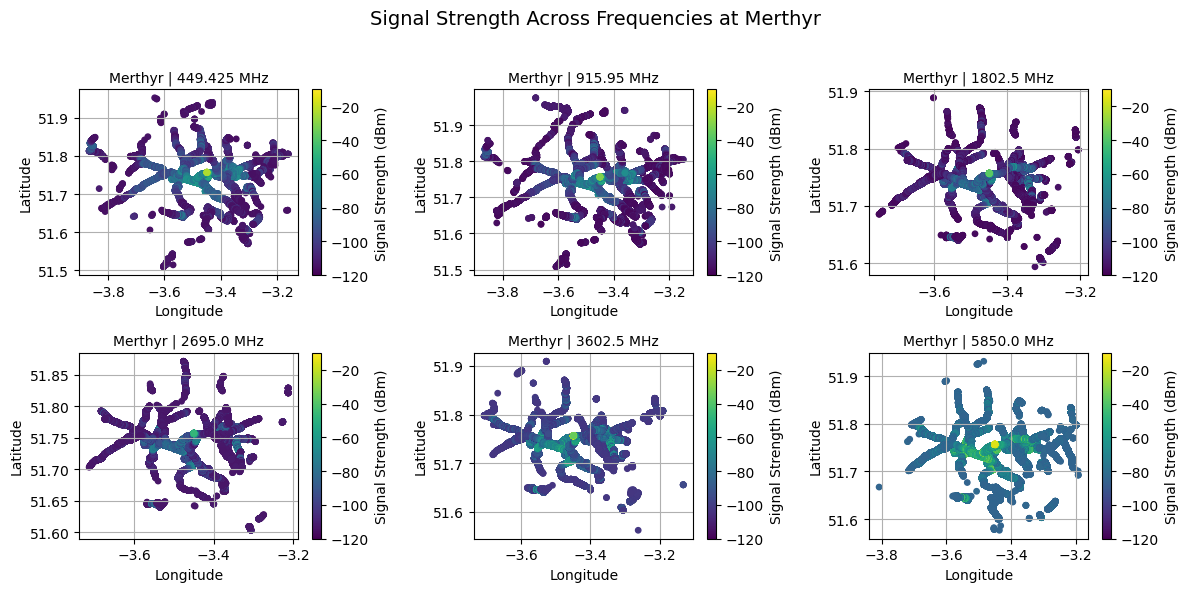

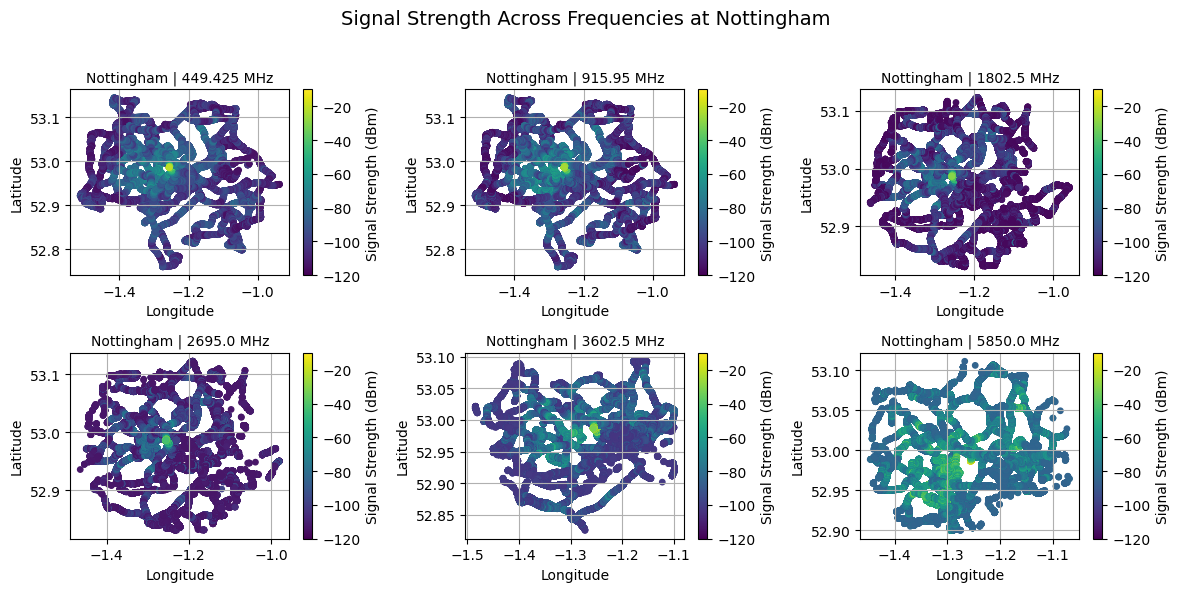

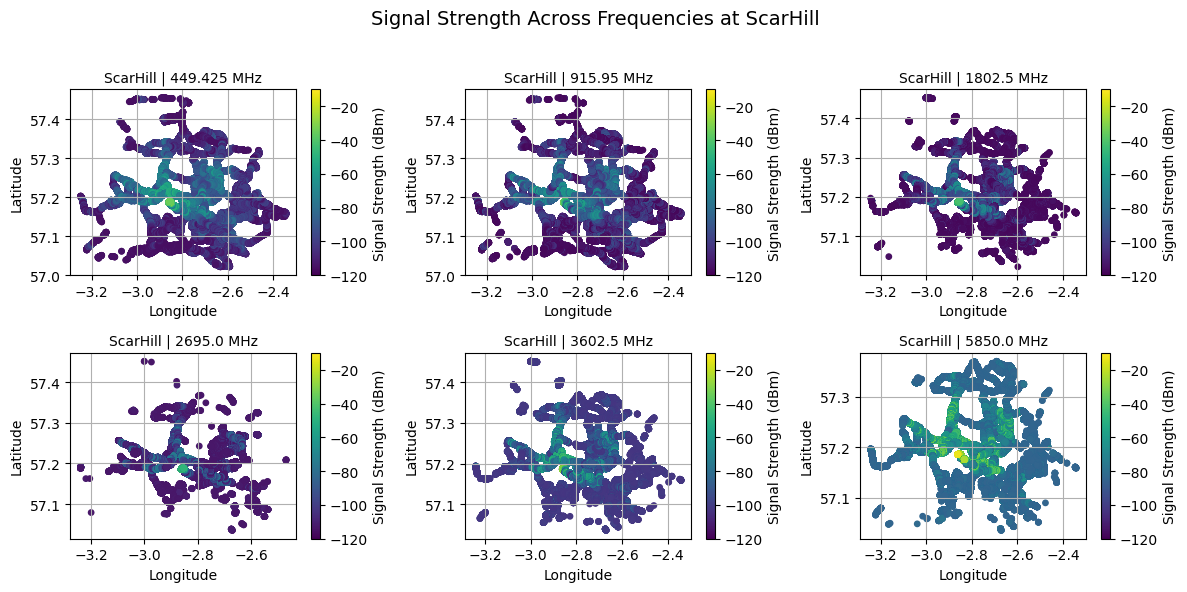

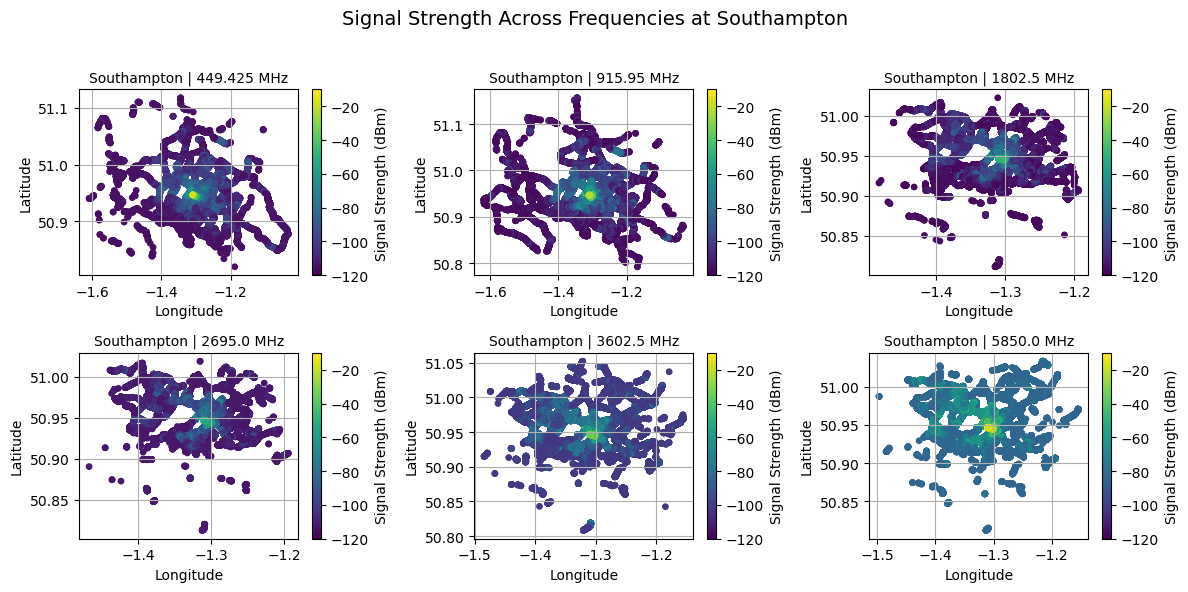

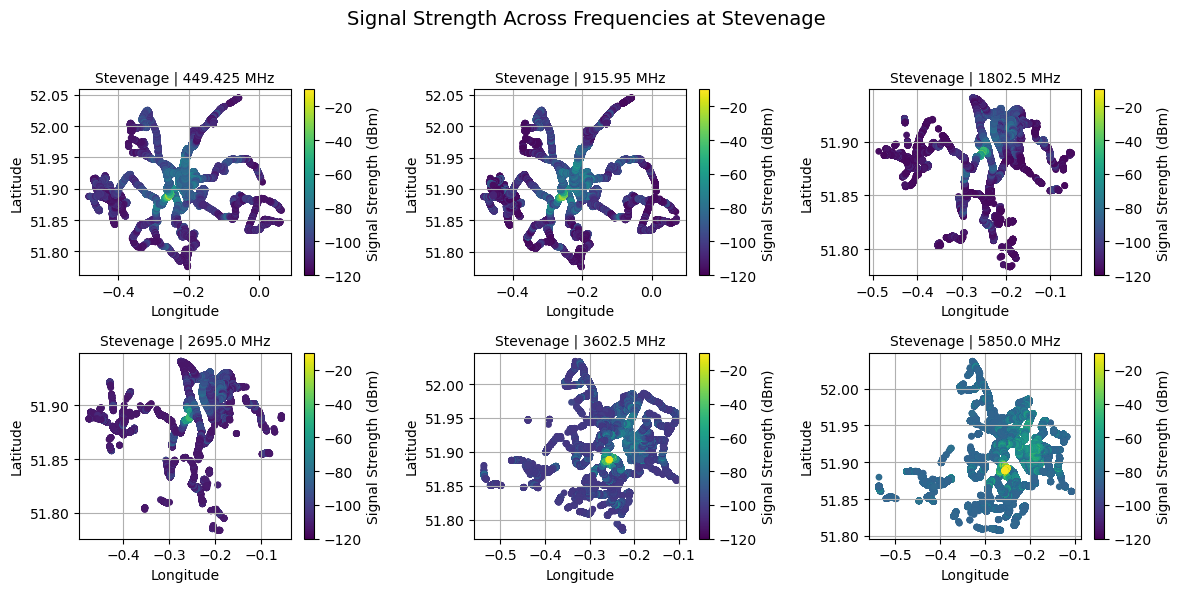

In [58]:

# --- Column definitions ---
lat_col = 'Rx Latitude (deg)'
lon_col = 'Rx Longitude (deg)'
signal_col = 'Local dBm'
site_col = 'Site name'
freq_col = 'Frequency (MHz)'

# --- Unique sites and frequencies ---
unique_sites = sorted(combined_df_filtered[site_col].dropna().unique())
unique_freqs = sorted(combined_df_filtered[freq_col].dropna().unique())

# --- Loop through each site and create one figure per site ---
for site in unique_sites:
    site_data = combined_df_filtered[combined_df_filtered[site_col] == site]

    # Set up 3x2 subplot grid (6 frequencies)
    fig, axes = plt.subplots(2, 3, figsize=(12, 6))
    axes = axes.flatten()  # Flatten to iterate easily

    for i, freq in enumerate(unique_freqs):
        freq_data = site_data[site_data[freq_col] == freq]
        ax = axes[i]

        if not freq_data.empty:
            sc = ax.scatter(freq_data[lon_col], freq_data[lat_col], c=freq_data[signal_col],
                            cmap='viridis', s=15, vmin=-120, vmax=-10)
            ax.set_title(f"{site} | {freq} MHz", fontsize=10)
            ax.set_xlabel("Longitude")
            ax.set_ylabel("Latitude")
            ax.grid(True)

            # Add colorbar to each subplot
            cbar = fig.colorbar(sc, ax=ax)
            cbar.set_label('Signal Strength (dBm)')
        else:
            ax.set_visible(False)

    # Hide any remaining unused subplots (if any)
    for j in range(len(unique_freqs), len(axes)):
        fig.delaxes(axes[j])

    # Title and layout
    fig.suptitle(f"Signal Strength Across Frequencies at {site}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Save each site figure
    plt.savefig(f"{site}_signal_strength_by_frequency.png", dpi=300, bbox_inches='tight')
    plt.show()

In [1]:
# Topographic Information of different sites present in the dataset.



#     Boston: Flat terrain with hills rising to the west of the transmitter location. The environment is predominantly open with sparse 
#                 vegetation and three small towns within the service area of the transmitter	

#     London: City, significant dense urban areas with developed land around the transmitter location

#     Merthyr Tydfil: A large town with mountainous surrounding areas. There is sparse urbanisation with some villages and suburbs	

#     Nottingham: A city in an area with rolling terrain. There are urban areas to the southeast and southwest of the transmitter locations 
#                 with a scattering of suburban and village areas to the northwest	
    
#     Scarhill: Mountainous terrain with dense and high vegetation. The terrain rises to the west of the transmitter to heights of greater than 
#                 800 m. To the east the ground height falls to approximately 100 m.	    

#     Southampton: A city in an area with a rolling terrain.  Some of the measured propagation paths are over water. The environment is mainly 
#                 open to the northeast and the urbanisation lies to the south of the transmitter site.	
    
#     Stevenage: A large town in a fairly flat area with urban areas surrounded by suburbs and villages.  	

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [60]:
summary_df = combined_df_filtered.groupby(['Site name','Frequency (MHz)'])['fresnel_radius_m'].agg(['min', 'max', 'mean', 'median', 'std']).reset_index()

## Modeling

### Data Prep for modeling

In [67]:
combined_df_model = combined_df_filtered.drop(columns = ["source_file"])

In [69]:
combined_df_model["Frequency (MHz)"].unique()

array([ 449.425, 3602.5  , 2695.   ,  915.95 , 1802.5  , 5850.   ])

In [71]:
# --- Convert object columns to numeric ---
for col in combined_df_model.select_dtypes(include='object').columns:
    combined_df_model[col] = pd.to_numeric(combined_df_model[col], errors='coerce')

# Drop rows with any missing values
combined_df_model = combined_df_model.dropna()

## Model 1: Frequency Level

In [ ]:
# --- Loop over unique frequencies ---
results = []
for freq in combined_df_model['Frequency (MHz)'].unique():
    print(f"\n=== Processing Frequency: {freq} MHz ===")

    df_freq = combined_df_model[combined_df_model['Frequency (MHz)'] == freq].copy()

    # Drop target and non-feature columns
    target = 'Local dBm'
    drop_cols = [target, 'Frequency (MHz)', 'datetime', 'Site name']  # remove string cols
    X = df_freq.drop(columns=drop_cols, errors='ignore')
    X = X.select_dtypes(include=[np.number])  # keep only numeric features
    y = df_freq[target]

    # Drop rows with NaNs *after* target + features are selected
    data = pd.concat([X, y], axis=1).dropna()
    if data.shape[0] < 10:
        print(f"Skipping {freq} MHz — not enough clean samples after dropna.")
        continue

    X = data.drop(columns=[target])
    y = data[target]

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # PCA
    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)

    # Train/Val/Test split
    X_temp, X_test, y_temp, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

    # Train model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Evaluate
    y_val_pred = rf.predict(X_val)
    y_test_pred = rf.predict(X_test)

    val_mse = mean_squared_error(y_val, y_val_pred)
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(y_val, y_val_pred)

    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"Validation MSE: {val_mse:.2f}, RMSE: {val_rmse:.2f}, R²: {val_r2:.2f}")
    print(f"Test MSE: {test_mse:.2f}, RMSE: {test_rmse:.2f}, R²: {test_r2:.2f}")




    # create folder to save plots
    os.makedirs("plots_actual_vs_predicted", exist_ok=True)
    
    # --- Combined Side-by-Side Plot ---
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    
    # Validation Plot
    axes[0].scatter(y_val, y_val_pred, alpha=0.5, label='Val Data', color='dodgerblue')
    axes[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
    axes[0].set_title(f"Validation Set - Frequency {freq} MHz")
    axes[0].set_xlabel("Actual Local dBm")
    axes[0].set_ylabel("Predicted Local dBm")
    axes[0].legend()
    axes[0].grid(True)
    
    # Test Plot
    axes[1].scatter(y_test, y_test_pred, alpha=0.5, label='Test Data', color='seagreen')
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axes[1].set_title(f"Test Set - Frequency {freq} MHz")
    axes[1].set_xlabel("Actual Local dBm")
    axes[1].set_ylabel("Predicted Local dBm")
    axes[1].legend()
    axes[1].grid(True)
    
    # Final layout
    plt.tight_layout()
    plt.savefig(f"plots_actual_vs_predicted/val_test_side_by_side_freq_{freq}.png")
    plt.show()
    
    results.append({
        "Frequency (MHz)": freq,
        "Val MSE": val_mse,
        "Val RMSE": val_rmse,
        "Val R²": val_r2,
        "Test MSE": test_mse,
        "Test RMSE": test_rmse,
        "Test R²": test_r2,
        "Num Samples": len(data)
    })

# --- Summary Table ---
# Summary Table
print("\n=== Summary of Results Across Frequencies ===")
results_df = pd.DataFrame(results)

# Optional: round for cleaner display
# display_cols = ["Frequency (MHz)", "Val MSE", "Val RMSE", "Val R²", "Test MSE", "Test RMSE", "Test R²", "Num Samples"]
# print(results_df[display_cols].sort_values(by="Frequency (MHz)").round(2).to_string(index=False))

# Ensure correct column name
if "Frequency (MHz)" not in results_df.columns:
    # Try fallback column names if key was wrong
    for col in results_df.columns:
        if "freq" in col.lower():
            results_df = results_df.rename(columns={col: "Frequency (MHz)"})
            break

# Now sorting
print(results_df.sort_values(by="Frequency (MHz)").to_string(index=False))

## Model 2: Combination of site and frequency

In [ ]:

def process_sites_and_frequencies_clean(
    df,
    target_col='Local dBm',
    group_cols=['Site name', 'Frequency (MHz)'],
    drop_cols_extra=['datetime'],
    save_dir='plots_grouped_clean',
):
    os.makedirs(save_dir, exist_ok=True)
    results = []

    for site in df[group_cols[0]].dropna().unique():
        freqs = df.loc[df[group_cols[0]] == site, group_cols[1]].dropna().unique()
        n_freqs = len(freqs)

        ncols = 3
        nrows = int(np.ceil(n_freqs / ncols))

        fig_val, axes_val = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
        fig_test, axes_test = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
        axes_val = axes_val.flatten()
        axes_test = axes_test.flatten()

        for i, freq in enumerate(freqs):
            df_sub = df[(df[group_cols[0]] == site) & (df[group_cols[1]] == freq)].copy()

            drop_cols = [target_col] + drop_cols_extra + group_cols
            X = df_sub.drop(columns=drop_cols, errors='ignore').select_dtypes(include=[np.number])
            y = df_sub[target_col]

            data = pd.concat([X, y], axis=1).dropna()
            if data.shape[0] < 20:  # skip small datasets
                continue

            X = data.drop(columns=[target_col])
            y = data[target_col]

            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            pca = PCA(n_components=0.95)
            X_pca = pca.fit_transform(X_scaled)

            # train/val/test split
            X_temp, X_test, y_temp, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
            X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

            rf = RandomForestRegressor(n_estimators=100, random_state=42)
            rf.fit(X_train, y_train)

            # validation
            y_val_pred = rf.predict(X_val)
            val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
            val_r2 = r2_score(y_val, y_val_pred)

            # test
            y_test_pred = rf.predict(X_test)
            test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
            test_r2 = r2_score(y_test, y_test_pred)

            # --- Validation plot ---
            ax_val = axes_val[i]
            ax_val.scatter(y_val, y_val_pred, alpha=0.5, color='dodgerblue')
            ax_val.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
            ax_val.set_title(f"{freq} MHz\nVal RMSE={val_rmse:.2f}, R²={val_r2:.2f}", fontsize=10)
            if i // ncols < nrows - 1:  # hide x-axis labels for non-bottom rows
                ax_val.set_xlabel("")
                ax_val.set_xticklabels([])
            else:
                ax_val.set_xlabel("Actual dBm")
            ax_val.set_ylabel("Predicted dBm")
            ax_val.grid(True)

            # --- Test plot ---
            ax_test = axes_test[i]
            ax_test.scatter(y_test, y_test_pred, alpha=0.5, color='seagreen')
            ax_test.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
            ax_test.set_title(f"{freq} MHz\nTest RMSE={test_rmse:.2f}, R²={test_r2:.2f}", fontsize=10)
            if i // ncols < nrows - 1:
                ax_test.set_xlabel("")
                ax_test.set_xticklabels([])
            else:
                ax_test.set_xlabel("Actual dBm")
            ax_test.set_ylabel("Predicted dBm")
            ax_test.grid(True)

            results.append({
                "Site": site,
                "Frequency (MHz)": freq,
                "Val RMSE": val_rmse,
                "Val R²": val_r2,
                "Test RMSE": test_rmse,
                "Test R²": test_r2,
                "Num Samples": len(data)
            })

        # remove unused axes
        for j in range(i+1, len(axes_val)):
            fig_val.delaxes(axes_val[j])
            fig_test.delaxes(axes_test[j])

        fig_val.suptitle(f"Validation Predictions - Site: {site}", fontsize=16)
        fig_test.suptitle(f"Test Predictions - Site: {site}", fontsize=16)

        fig_val.tight_layout(rect=[0, 0.03, 1, 0.95])
        fig_test.tight_layout(rect=[0, 0.03, 1, 0.95])

        fig_val.savefig(f"{save_dir}/{site.replace(' ','_')}_val.png", dpi=300)
        fig_test.savefig(f"{save_dir}/{site.replace(' ','_')}_test.png", dpi=300)
        plt.close(fig_val)
        plt.close(fig_test)

    results_df = pd.DataFrame(results)

    # Combined summary (site + frequency)
    summary = (
        results_df.groupby(["Site", "Frequency (MHz)"])
        .agg({
            "Val RMSE": "mean",
            "Val R²": "mean",
            "Test RMSE": "mean",
            "Test R²": "mean",
            "Num Samples": "sum"
        })
        .reset_index()
    )

    # Separate summary per site
    site_summaries = {}
    for site, df_site in results_df.groupby("Site"):
        site_summary = (
            df_site.groupby("Frequency (MHz)")
            .agg({
                "Val RMSE": "mean",
                "Val R²": "mean",
                "Test RMSE": "mean",
                "Test R²": "mean",
                "Num Samples": "sum"
            })
            .reset_index()
        )
        site_summaries[site] = site_summary

    return results_df, summary, site_summaries

In [ ]:
results_df, summary, site_summaries = process_sites_and_frequencies_clean(
    df=combined_df_model,
    target_col='Local dBm',
    group_cols=['Site name', 'Frequency (MHz)'],
    save_dir='plots_actual_vs_predicted'
)

In [ ]:
site_summaries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

def process_sites_and_frequencies(
    df,
    target_col='Local dBm',
    group_cols=['Site name', 'Frequency (MHz)'],
    drop_cols_extra=['datetime'],
    save_dir='plots_actual_vs_predicted',
    outlier_dir='outliers',
    std_multiplier=2.5
):
    """
    Trains a RandomForest model on each (site, frequency) pair,
    plots actual vs predicted, and detects outliers by residuals.

    Returns:
        results_df: pd.DataFrame with model performance per group
    """
    
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(outlier_dir, exist_ok=True)

    results = []

    # Loop over all unique (site, freq) pairs
    for (site, freq) in df[group_cols].dropna().drop_duplicates().values:
        print(f"\n=== Processing Site: {site}, Frequency: {freq} MHz ===")

        # Subset
        df_sub = df[(df[group_cols[0]] == site) & (df[group_cols[1]] == freq)].copy()

        # Define target and features
        drop_cols = [target_col] + drop_cols_extra + group_cols
        X = df_sub.drop(columns=drop_cols, errors='ignore').select_dtypes(include=[np.number])
        y = df_sub[target_col]

        # Drop rows with NaNs
        data = pd.concat([X, y], axis=1).dropna()
        if data.shape[0] < 10:
            print(f"Skipping {site}, {freq} MHz — not enough clean samples.")
            continue

        X = data.drop(columns=[target_col])
        y = data[target_col]

        # Standardize and PCA
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        pca = PCA(n_components=0.95)
        X_pca = pca.fit_transform(X_scaled)

        # Split data
        X_temp, X_test, y_temp, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

        # Train model
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)

        # Predict
        y_val_pred = rf.predict(X_val)
        y_test_pred = rf.predict(X_test)

        # Metrics
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        val_r2 = r2_score(y_val, y_val_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_r2 = r2_score(y_test, y_test_pred)

        print(f"Validation RMSE: {val_rmse:.2f}, R²: {val_r2:.2f}")
        print(f"Test RMSE: {test_rmse:.2f}, R²: {test_r2:.2f}")

        # --- OUTLIER DETECTION ---
        residuals = y_val - y_val_pred
        std_dev = np.std(residuals)
        threshold = std_multiplier * std_dev
        val_df = pd.DataFrame({
            "Actual": y_val,
            "Predicted": y_val_pred,
            "Residual": residuals
        })
        outliers = val_df[np.abs(val_df["Residual"]) > threshold]
        cleaned_site = str(site).replace(" ", "_").replace("/", "_")

        outlier_path = f"{outlier_dir}/outliers_{cleaned_site}_{freq}MHz.csv"
        outliers.to_csv(outlier_path, index=False)
        print(f"Outliers detected: {len(outliers)} (saved to {outlier_path})")

        # Plot Residual Histogram
        plt.figure(figsize=(6, 4))
        plt.hist(residuals, bins=50, color='steelblue', edgecolor='k')
        plt.axvline(threshold, color='red', linestyle='--', label=f'±{std_multiplier}σ')
        plt.axvline(-threshold, color='red', linestyle='--')
        plt.title(f"Residuals: {site}, {freq} MHz")
        plt.xlabel("Residual (Actual - Predicted)")
        plt.ylabel("Frequency")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{save_dir}/residuals_{cleaned_site}_{freq}MHz.png")
        plt.close()

        # Plot Actual vs Predicted - Validation
        plt.figure(figsize=(6, 5))
        plt.scatter(y_val, y_val_pred, alpha=0.5, label='Val Data', color='dodgerblue')
        plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
        plt.xlabel("Actual Local dBm")
        plt.ylabel("Predicted Local dBm")
        plt.title(f"Val - Site: {site}, Freq: {freq} MHz")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{save_dir}/val_{cleaned_site}_{freq}MHz.png")
        plt.close()

        # Plot Actual vs Predicted - Test
        plt.figure(figsize=(6, 5))
        plt.scatter(y_test, y_test_pred, alpha=0.5, label='Test Data', color='seagreen')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel("Actual Local dBm")
        plt.ylabel("Predicted Local dBm")
        plt.title(f"Test - Site: {site}, Freq: {freq} MHz")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{save_dir}/test_{cleaned_site}_{freq}MHz.png")
        plt.close()

        # Append results
        results.append({
            "Site": site,
            "Frequency (MHz)": freq,
            "Validation RMSE": val_rmse,
            "Validation R²": val_r2,
            "Test RMSE": test_rmse,
            "Test R²": test_r2,
            "Num Samples": len(data),
            "Outliers Detected": len(outliers)
        })

    # Final summary
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by=["Site", "Frequency (MHz)"])
    print("\n=== Summary of Results Across Sites and Frequencies ===")
    print(results_df.to_string(index=False))

    return results_df

In [ ]:
results_df = process_sites_and_frequencies_png(
    df=combined_df_model,
    target_col='Local dBm',
    group_cols=['Site name', 'Frequency (MHz)'],
    save_dir='plots_actual_vs_predicted',
    outlier_dir='outliers',
    std_multiplier=2.5 
)
# results_df.to_csv("Data/Output/summary_model_results.csv", index=False)

## Model 3: Running on Site frequency combination after removing outliers detected

### Defining outliers

In [ ]:
def extract_outliers_iqr(df, target_col, group_cols=None, iqr_multiplier=1.5, save_path=None):
    """
    Extracts outliers based on IQR method for the target column.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        target_col (str): Column name to detect outliers on.
        group_cols (list of str or None): Columns to group by (e.g., ['Site name', 'Frequency (MHz)']).
        iqr_multiplier (float): Multiplier for IQR (default: 1.5).
        save_path (str or None): If provided, saves CSV to this path.
    
    Returns:
        pd.DataFrame: DataFrame containing only the outliers.
    """
    outliers_list = []

    if group_cols is None:
        group_cols = []

    grouped = df.groupby(group_cols) if group_cols else [(None, df)]

    for group_key, group_df in grouped:
        y = group_df[target_col]

        Q1 = y.quantile(0.25)
        Q3 = y.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - iqr_multiplier * IQR
        upper = Q3 + iqr_multiplier * IQR

        mask = (y < lower) | (y > upper)
        outlier_rows = group_df[mask].copy()
        
        if group_cols:
            # Add group keys to each row if grouped
            if isinstance(group_key, tuple):
                for col, val in zip(group_cols, group_key):
                    outlier_rows[col] = val
            else:
                outlier_rows[group_cols[0]] = group_key
        
        outliers_list.append(outlier_rows)

    outliers_df = pd.concat(outliers_list, ignore_index=True)

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        outliers_df.to_csv(save_path, index=False)
        print(f"Outliers saved to: {save_path}")

    return outliers_df

In [ ]:
outliers_df = extract_outliers_iqr(
    df=combined_df_model,
    target_col='Local dBm',
    group_cols=['Site name', 'Frequency (MHz)'],
    iqr_multiplier=1.5,
    save_path='Data/Output/all_outliers_boxplot.csv'
)

## Model 4:  Deep Learning Model

In [74]:
# Example: get all unique sites
sites = combined_df_model["Site name"].unique()

# Train/val/test split at site level (not random row-level split!)
train_sites, test_sites = train_test_split(sites, test_size=0.2, random_state=42)
train_sites, val_sites  = train_test_split(train_sites, test_size=0.25, random_state=42)  
# (so ~60% train, 20% val, 20% test)

# Filter data by sites
train_df = combined_df_model[combined_df_model["Site name"].isin(train_sites)]
val_df   = combined_df_model[combined_df_model["Site name"].isin(val_sites)]
test_df  = combined_df_model[combined_df_model["Site name"].isin(test_sites)]

X_train, y_train = train_df.drop(columns=["Local dBm"]), train_df["Local dBm"]
X_val, y_val     = val_df.drop(columns=["Local dBm"]), val_df["Local dBm"]
X_test, y_test   = test_df.drop(columns=["Local dBm"]), test_df["Local dBm"]

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler

# ----------------------------------------------------
# (Optional) Force CPU if you don't want GPU usage
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Limit threads (prevents Mac kernel crashes)
tf.config.threading.set_intra_op_parallelism_threads(2)
tf.config.threading.set_inter_op_parallelism_threads(2)

# ----------------------------------------------------
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# ----------------------------------------------------
# Build model (lighter version to save memory)
model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)   # Regression output
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

# ----------------------------------------------------
# Create tf.data pipelines (efficient memory handling)
BATCH_SIZE = 8   # smaller batch size to prevent kernel death

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train))
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# ----------------------------------------------------
# Add EarlyStopping to avoid unnecessary training
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# ----------------------------------------------------
# Train model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[callback],
    verbose=1
)

# ----------------------------------------------------
# Evaluate on test set
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE)

test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# ----------------------------------------------------
# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test_scaled).flatten()

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

In [ ]:
frequencies = combined_df_model["Frequency (MHz)"].unique()

results = []
for freq in frequencies:
    df_freq = combined_df_model[combined_df_model["Frequency (MHz)"] == freq]
    # Repeat site-based split + training + evaluation
    # Store results (MSE, RMSE, R²) in `results`

In [ ]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

def build_mlp(in_dim, activation="relu", l2=1e-4, dropout=0.2):
    act_layer = (lambda: layers.LeakyReLU(alpha=0.01)) if activation=="leaky_relu" else activation
    def act(x):
        return layers.LeakyReLU(alpha=0.01)(x) if activation=="leaky_relu" else layers.Activation(activation)(x)
    inputs = layers.Input(shape=(in_dim,))
    x = layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(l2))(inputs); x = act(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(l2))(x); x = act(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1)(x)  # linear for regression
    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse", metrics=["mae"])
    return model

def site_split(df, site_col, train_sites, val_sites, target_col):
    tr = df[df[site_col].isin(train_sites)]
    va = df[df[site_col].isin(val_sites)]
    Xtr = tr.drop(columns=[target_col, site_col, "Frequency (MHz)"], errors="ignore").select_dtypes(include=[np.number])
    Xva = va.drop(columns=[target_col, site_col, "Frequency (MHz)"], errors="ignore").select_dtypes(include=[np.number])
    ytr, yva = tr[target_col].values, va[target_col].values
    scaler = StandardScaler()
    Xtr_s = scaler.fit_transform(Xtr); Xva_s = scaler.transform(Xva)
    return Xtr_s, ytr, Xva_s, yva, scaler

def evaluate_activation_by_freq(df, site_col="Site name", target_col="Local dBm"):
    results = []
    for freq in sorted(df["Frequency (MHz)"].dropna().unique()):
        dfF = df[df["Frequency (MHz)"] == freq].dropna()
        sites = dfF[site_col].dropna().unique()
        if len(sites) < 3: 
            continue
        # hold out one site for validation (rotate this in your real LOSO loop)
        val_site = np.random.choice(sites, 1, replace=False)[0]
        train_sites = [s for s in sites if s != val_site]
        Xtr, ytr, Xva, yva, _ = site_split(dfF, site_col, train_sites, [val_site], target_col)
        for act in ["relu", "leaky_relu", "elu", "gelu"]:
            model = build_mlp(Xtr.shape[1], activation=act)
            es = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
            model.fit(Xtr, ytr, validation_data=(Xva, yva), epochs=200, batch_size=256, verbose=0, callbacks=[es])
            pred = model.predict(Xva, verbose=0).ravel()
            mse = mean_squared_error(yva, pred); rmse = np.sqrt(mse); r2 = r2_score(yva, pred)
            results.append({"Frequency (MHz)": freq, "Val Site": val_site, "Activation": act,
                            "Val MSE": mse, "Val RMSE": rmse, "Val R2": r2})
    return pd.DataFrame(results)

In [ ]:
# Example: one-hot frequency
freq_ohe = pd.get_dummies(combined_df_model["Frequency (MHz)"].astype(str), prefix="FREQ")
X_num = combined_df_model.drop(columns=["Local dBm","Site name","Frequency (MHz)"], errors="ignore").select_dtypes(include=[np.number])
X_all = pd.concat([X_num, freq_ohe], axis=1)
y_all = combined_df_model["Local dBm"].values

# Site-level split (train on some sites, validate on held-out)
train_sites = [...]  # choose
val_sites = [...]
Xtr = X_all[combined_df_model["Site name"].isin(train_sites)]
Xva = X_all[combined_df_model["Site name"].isin(val_sites)]
ytr = y_all[combined_df_model["Site name"].isin(train_sites)]
yva = y_all[combined_df_model["Site name"].isin(val_sites)]
# scale, build MLP (same as above), train, evaluate RMSE.

In [ ]:
# assumes freq_ohe as above and we still predict one target, but route to head by freq
freq_labels = sorted(combined_df_model["Frequency (MHz)"].dropna().unique())
freq_to_idx = {f:i for i,f in enumerate(freq_labels)}

# Build shared trunk
inp = layers.Input(shape=(X_num.shape[1],))
x = layers.Dense(128, activation="relu")(inp)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu")(x)

# Heads
outs = [layers.Dense(1, name=f"head_{i}")(x) for i in range(len(freq_labels))]
model = models.Model(inp, outs)

model.compile(optimizer="adam", loss="mse")

# Prepare outputs per head (None for other heads)
def make_multitask_targets(y, freq_series):
    Y = []
    for i,f in enumerate(freq_labels):
        yy = y.copy().astype(float)
        mask = (freq_series == f)
        yy[~mask] = np.nan  # Keras masks NaN in losses
        Y.append(yy)
    return Y

# Train with site-level split; feed [Xtr] and list of Ytr heads; validate similarly.